# Prediciting Match Outcomes

## Introduction

When someone is prepared to risk money, small or large, on their favourite sports team or simply as a bit of casual fun or may it be they are trying to make money. There is only one main aim and that is to beat the bookies and generate a higher return than initally staked.  

The casual gambler might be putting on bets for their favorite sports team and may play based off emotions rather than informed decisions which more than likely leads to a number of losses.  

However the professional sports bettor will use a combination of information and experience to understand whether the odds offered by the bookies are in favour of the house or not. They do not bet based off emotions but off years of experience and research. 

This project aims to replicate the knowledge that a professional punter would use to determine whether a bet is worth risking money on, whilst every individual has their own risk appetite we hope the models built in this project will be able to predict outcomes based on statistical properties of past matches. 

This could then aid bettors in making their decisions on what outcome to bet on and potentially beat the bookies. 

Using a dataset provided by https://www.football-data.co.uk/ that contains match data as well as FIFA player statistics, I will build a model to predict the probability of each match outcome where the outcome is one of - Win, Draw or Loss. 

In [1]:
# Import packages

import numpy as np
import sqlite3
import pandas as pd
import seaborn as sns
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, make_scorer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score, confusion_matrix, roc_auc_score, classification_report, log_loss

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

warnings.simplefilter(action="ignore")


In [2]:
years = np.arange(5,23) 
years_1 = np.arange(6,24)

## Convert to string and add trailing 0 
## required for website url data is stored on 

years = years.astype(str)
years = np.char.zfill(years, 2)

years_1 = years_1.astype(str)
years_1 = np.char.zfill(years_1, 2)

## Combining to give out the final years
url_years = np.core.defchararray.add(years, years_1)

data_url_base = 'https://www.football-data.co.uk/mmz4281/{Year}/E0.csv'


## Check if the data already exists locally (previously compiled incase of no internet)

if os.path.exists("data/football_data.csv"):
    df = pd.read_csv("data/football_data.csv", low_memory=False, index_col=False)
else:
    ## creating url list with all years needed
    ## Also adding delimiter '/' between seasons for new column 
    data_urls_list = []
    season = []
    for year in url_years:
        url_with_year = data_url_base.replace('{Year}', year)
        season_year = year[:2] + '/' + year[2:]
        season.append(season_year)
        data_urls_list.append(url_with_year)

    df_list =[] 

    for file in enumerate(data_urls_list):
        df = pd.read_csv(file[1])
        df['Season'] = season[file[0]]
        df_list.append(df)
    
    df = pd.concat(df_list, ignore_index=True)

cols_to_keep = ['Date','Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR','Season']

df = df[cols_to_keep]

# Keeping one df for current season to run predictions on 
df_latest_season = df[df.Season == "22/23"]

## Removing latest season as season not finished 
df = df[df.Season != "22/23"]

# Convert Date and Time columns 

df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'], format="%H:%M").dt.time

# Replacing some names as seem to be incomplete from older seasons
df.replace('D Gallaghe', 'D Gallagher', inplace=True)
df.replace('D Gallagh', 'D Gallagher', inplace=True)
df.replace('Mn Atkinson', 'M Atkinson', inplace=True)
df.replace('l Mason', 'L Mason', inplace=True)

df.dropna(inplace=True)
df.isna().sum()

Date        0
Time        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
Referee     0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
Season      0
dtype: int64

In [3]:
# Create Home Win, Draw Win and Away Win columns
df = df.assign(homeWin=lambda df: df.apply(lambda row: 1 if row.FTHG > row.FTAG else 0, axis='columns'),
              draw=lambda df: df.apply(lambda row: 1 if row.FTHG == row.FTAG else 0, axis='columns'),
              awayWin=lambda df: df.apply(lambda row: 1 if row.FTHG < row.FTAG else 0, axis='columns'))

## Data

In [4]:
display(df)

Date      Time        HomeTeam          AwayTeam  FTHG  FTAG FTR  \
5321 2019-09-08  20:00:00       Liverpool           Norwich   4.0   1.0   H   
5322 2019-10-08  12:30:00        West Ham          Man City   0.0   5.0   A   
5323 2019-10-08  15:00:00     Bournemouth  Sheffield United   1.0   1.0   D   
5324 2019-10-08  15:00:00         Burnley       Southampton   3.0   0.0   H   
5325 2019-10-08  15:00:00  Crystal Palace           Everton   0.0   0.0   D   
...         ...       ...             ...               ...   ...   ...  ..   
6456 2022-05-22  16:00:00  Crystal Palace        Man United   1.0   0.0   H   
6457 2022-05-22  16:00:00       Leicester       Southampton   4.0   1.0   H   
6458 2022-05-22  16:00:00       Liverpool            Wolves   3.0   1.0   H   
6459 2022-05-22  16:00:00        Man City       Aston Villa   3.0   2.0   H   
6460 2022-05-22  16:00:00         Norwich         Tottenham   0.0   5.0   A   

         Referee    HS    AS  ...    HC   AC   HY   AY   HR   AR  Season  \
5321    M Oliver  15.0  12.0  ...  11.0  2.0  0.0  2.0  0.0  0.0   19/20   
5322      M Dean   5.0  14.0  ...   1.0  1.0  2.0  2.0  0.0  0.0   19/20   
5323    K Friend  13.0   8.0  ...   3.0  4.0  2.0  1.0  0.0  0.0   19/20   
5324     G Scott  10.0  11.0  ...   2.0  7.0  0.0  0.0  0.0  0.0   19/20   
5325      J Moss   6.0  10.0  ...   6.0  2.0  2.0  1.0  0.0  1.0   19/20   
...          ...   ...   ...  ...   ...  ...  ...  ...  ...  ...     ...   
6456  M Atkinson   6.0  10.0  ...   3.0  6.0  2.0  4.0  0.0  0.0   21/22   
6457      J Moss  12.0   7.0  ...   3.0  3.0  0.0  1.0  0.0  0.0   21/22   
6458    A Taylor  29.0   7.0  ...   5.0  3.0  1.0  0.0  0.0  0.0   21/22   
6459    M Oliver  24.0   4.0  ...  13.0  1.0  0.0  1.0  0.0  0.0   21/22   
6460  C Kavanagh   9.0  19.0  ...   3.0  2.0  3.0  1.0  0.0  0.0   21/22   

      homeWin  draw  awayWin  
5321        1     0        0  
5322        0     0        1  
5323        0     1        0  
5324        1     0        0  
5325        0     1        0  
...       ...   ...      ...  
6456        1     0        0  
6457        1     0        0  
6458        1     0        0  
6459        1     0        0  
6460        0     0        1  

[1140 rows x 24 columns]

## Summary Statistics

In [5]:
df.describe()

FTHG         FTAG           HS           AS          HST  \
count  1140.000000  1140.000000  1140.000000  1140.000000  1140.000000   
mean      1.460526     1.284211    13.328947    11.500000     4.592982   
std       1.300106     1.239501     5.535554     5.163609     2.570369   
min       0.000000     0.000000     1.000000     1.000000     0.000000   
25%       0.000000     0.000000     9.000000     8.000000     3.000000   
50%       1.000000     1.000000    13.000000    11.000000     4.000000   
75%       2.000000     2.000000    17.000000    15.000000     6.000000   
max       9.000000     9.000000    31.000000    31.000000    15.000000   

               AST           HF           AF           HC           AC  \
count  1140.000000  1140.000000  1140.000000  1140.000000  1140.000000   
mean      4.073684    10.587719    10.563158     5.644737     4.794737   
std       2.448380     3.519197     3.649775     3.095370     2.747170   
min       0.000000     0.000000     1.000000     0.000000     0.000000   
25%       2.000000     8.000000     8.000000     3.000000     3.000000   
50%       4.000000    11.000000    10.000000     5.000000     4.000000   
75%       5.250000    13.000000    13.000000     7.000000     6.000000   
max      15.000000    23.000000    25.000000    17.000000    16.000000   

                HY           AY           HR           AR      homeWin  \
count  1140.000000  1140.000000  1140.000000  1140.000000  1140.000000   
mean      1.554386     1.652632     0.052632     0.064912     0.420175   
std       1.207101     1.211027     0.231121     0.256943     0.493804   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     0.000000     0.000000     0.000000   
50%       1.000000     2.000000     0.000000     0.000000     0.000000   
75%       2.000000     2.000000     0.000000     0.000000     1.000000   
max       6.000000     6.000000     2.000000     2.000000     1.000000   

              draw      awayWin  
count  1140.000000  1140.000000  
mean      0.230702     0.349123  
std       0.421467     0.476902  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     1.000000  
max       1.000000     1.000000

### Contingency tables



In [6]:
#Display some contingency tables to show high level frequency distribution of some key variables that may affect result
dfHTeamResultCont = pd.crosstab(df['HomeTeam'], 
                             df['FTR'], margins=False)
            
dfATeamResultCont = pd.crosstab(df['AwayTeam'], 
                             df['FTR'], margins=False)

dfRefResult = pd.crosstab(df['Referee'],
                             df['FTR'])


print("Home team vs Full Time Result")           
display(dfHTeamResultCont)

print("Away team vs Full Time Result")
display(dfATeamResultCont)

print("Referee vs Full Time Result")
display(dfRefResult)

Home team vs Full Time Result


FTR                A   D   H
HomeTeam                    
Arsenal           14  12  31
Aston Villa       25  12  20
Bournemouth        8   6   5
Brentford          9   3   7
Brighton          20  23  14
Burnley           24  16  17
Chelsea           12  16  29
Crystal Palace    20  18  19
Everton           21  13  23
Fulham            13   4   2
Leeds             15  11  12
Leicester         18   9  30
Liverpool          6   8  43
Man City           8   6  43
Man United        12  16  29
Newcastle         18  19  20
Norwich           25   6   7
Sheffield United  19   4  15
Southampton       24  13  20
Tottenham         15   7  35
Watford           22   8   8
West Brom         10   6   3
West Ham          19  13  25
Wolves            21  14  22

Away team vs Full Time Result


FTR                A   D   H
AwayTeam                    
Arsenal           23  12  22
Aston Villa       18   9  30
Bournemouth        4   1  14
Brentford          6   4   9
Brighton          16  20  21
Burnley           15  16  26
Chelsea           31  11  15
Crystal Palace    15  15  27
Everton           18  11  28
Fulham             3   9   7
Leeds             15   5  18
Leicester         22  15  20
Liverpool         37  12   8
Man City          39   8  10
Man United        26  17  14
Newcastle         16  11  30
Norwich            3   7  28
Sheffield United   6  10  22
Southampton       16  14  27
Tottenham         21  17  19
Watford            6   7  25
West Brom          2   5  12
West Ham          20  12  25
Wolves            20  15  22

Referee vs Full Time Result


FTR            A   D   H
Referee                 
A Madley      13  11  19
A Marriner    27  19  22
A Moss         1   0   0
A Taylor      28  21  39
C Kavanagh    22  14  30
C Pawson      25  16  31
D Coote       21  12  24
D England     10   7  10
G Scott       17   6  20
J Brooks       2   1   1
J Gillett      3   2   4
J Moss        24  14  36
K Friend      26  13  29
L Mason        7   7  13
M Atkinson    30  15  39
M Dean        24  22  32
M Oliver      36  16  34
M Salisbury    1   0   2
O Langford     0   1   0
P Bankes      12  10  17
P Tierney     25  21  27
R Jones        9   7   6
S Attwell     21  17  26
S Hooper      13   9  16
S Scott        0   1   0
T Harrington   1   1   1
T Robinson     0   0   1

In [7]:
# As seen in the above table there are referees who are either new or havent officiated many games. 
# For this project I will be removing those referees who haven't officiated more than 30 games. 

df = df[df.groupby('Referee')['Referee'].transform('size') >30]

Do referees influence the game? A lot of sports bettors are aware of what is known as the home advantage and is this something that they should be wary of when placing bets?
If referees are biased towards the home team you may want to take this into account when making your selection. 

In [8]:
print('Home Win Rate: {:.4}%'.format(df.homeWin.mean() * 100))

print("Home Win Rate by Ref")
df.groupby('Referee').homeWin.mean().sort_values(ascending=False)

Home Win Rate: 42.36%
Home Win Rate by Ref


Referee
J Moss        0.486486
G Scott       0.465116
M Atkinson    0.464286
C Kavanagh    0.454545
A Taylor      0.443182
A Madley      0.441860
P Bankes      0.435897
C Pawson      0.430556
K Friend      0.426471
S Hooper      0.421053
D Coote       0.421053
M Dean        0.410256
S Attwell     0.406250
M Oliver      0.395349
P Tierney     0.369863
A Marriner    0.323529
Name: homeWin, dtype: float64

Jonathan Moss has the highest win rate for home sides. Does this mean he shows bias towards them?   
That is not neccesarily the case, it could just be that he is regularly in charge of teams towards the top end of the league table who tend to have a higher win rate as their team performs much better regularly.  

However this isn't to say that there is no relationship between referees and the Full Time Result

In [9]:
# Performing Chi Squared tests on these two variables to see if any significance can be drawn from the statement made 
from scipy.stats import chi2_contingency



# Create a contingency table
contingencyTableRef = pd.crosstab(df['Referee'], df['FTR'])

# Calculate chi-squared statistic and p-value
chi2, p, dof, expected = chi2_contingency(contingencyTableRef)

if p < 0.05:
    print("There is a significant association between Referee in charge and the Full Time Result")
else:
    print("There is no significant association between the Referee in charge and the Full Time Result")

There is no significant association between the Referee in charge and the Full Time Result


### Correlation matrix and plot

In [10]:
## Keeping only continuous columns 

df_continuous = df.select_dtypes(include=[np.number])

c_matrix = df_continuous.corr()
c_matrix


FTHG      FTAG        HS        AS       HST       AST        HF  \
FTHG     1.000000 -0.184300  0.362554 -0.232016  0.628939 -0.186796 -0.071237   
FTAG    -0.184300  1.000000 -0.228619  0.414921 -0.228001  0.640710 -0.046533   
HS       0.362554 -0.228619  1.000000 -0.447190  0.677011 -0.320273 -0.040009   
AS      -0.232016  0.414921 -0.447190  1.000000 -0.323177  0.714275 -0.025531   
HST      0.628939 -0.228001  0.677011 -0.323177  1.000000 -0.259835 -0.021608   
AST     -0.186796  0.640710 -0.320273  0.714275 -0.259835  1.000000 -0.003828   
HF      -0.071237 -0.046533 -0.040009 -0.025531 -0.021608 -0.003828  1.000000   
AF      -0.049878  0.002178 -0.062436  0.002558 -0.043578  0.019150  0.146960   
HC       0.072897 -0.148911  0.536140 -0.343443  0.307736 -0.250979  0.013335   
AC      -0.125317  0.079811 -0.322532  0.532490 -0.202910  0.302708 -0.044836   
HY      -0.163143  0.058444 -0.097544  0.102514 -0.135672  0.070846  0.355035   
AY      -0.015882 -0.054551  0.068058 -0.074939  0.036548 -0.062423  0.094496   
HR      -0.082862  0.131833 -0.095778  0.176280 -0.074561  0.156676  0.026001   
AR       0.102707 -0.119564  0.091594 -0.146398  0.111779 -0.147194  0.019907   
homeWin  0.663004 -0.532392  0.266390 -0.296123  0.469509 -0.372773 -0.019353   
draw    -0.202122 -0.133685 -0.017450  0.008331 -0.101191 -0.078782  0.048428   
awayWin -0.509546  0.669052 -0.260716  0.299533 -0.397664  0.455446 -0.022468   

               AF        HC        AC        HY        AY        HR        AR  \
FTHG    -0.049878  0.072897 -0.125317 -0.163143 -0.015882 -0.082862  0.102707   
FTAG     0.002178 -0.148911  0.079811  0.058444 -0.054551  0.131833 -0.119564   
HS      -0.062436  0.536140 -0.322532 -0.097544  0.068058 -0.095778  0.091594   
AS       0.002558 -0.343443  0.532490  0.102514 -0.074939  0.176280 -0.146398   
HST     -0.043578  0.307736 -0.202910 -0.135672  0.036548 -0.074561  0.111779   
AST      0.019150 -0.250979  0.302708  0.070846 -0.062423  0.156676 -0.147194   
HF       0.146960  0.013335 -0.044836  0.355035  0.094496  0.026001  0.019907   
AF       1.000000 -0.065241 -0.004839  0.083838  0.329814  0.031696  0.051633   
HC      -0.065241  1.000000 -0.264120 -0.014135  0.052026 -0.098332  0.065223   
AC      -0.004839 -0.264120  1.000000  0.032933 -0.023287  0.060620 -0.095270   
HY       0.083838 -0.014135  0.032933  1.000000  0.191212  0.000338  0.030948   
AY       0.329814  0.052026 -0.023287  0.191212  1.000000  0.017473  0.018681   
HR       0.031696 -0.098332  0.060620  0.000338  0.017473  1.000000 -0.029698   
AR       0.051633  0.065223 -0.095270  0.030948  0.018681 -0.029698  1.000000   
homeWin -0.014662  0.081651 -0.064976 -0.147715 -0.001821 -0.089099  0.110007   
draw     0.020306  0.030211 -0.000670  0.101261  0.037779 -0.046043  0.029716   
awayWin -0.002636 -0.111134  0.067917  0.064154 -0.031284  0.132752 -0.140082   

          homeWin      draw   awayWin  
FTHG     0.663004 -0.202122 -0.509546  
FTAG    -0.532392 -0.133685  0.669052  
HS       0.266390 -0.017450 -0.260716  
AS      -0.296123  0.008331  0.299533  
HST      0.469509 -0.101191 -0.397664  
AST     -0.372773 -0.078782  0.455446  
HF      -0.019353  0.048428 -0.022468  
AF      -0.014662  0.020306 -0.002636  
HC       0.081651  0.030211 -0.111134  
AC      -0.064976 -0.000670  0.067917  
HY      -0.147715  0.101261  0.064154  
AY      -0.001821  0.037779 -0.031284  
HR      -0.089099 -0.046043  0.132752  
AR       0.110007  0.029716 -0.140082  
homeWin  1.000000 -0.464196 -0.628637  
draw    -0.464196  1.000000 -0.397022  
awayWin -0.628637 -0.397022  1.000000

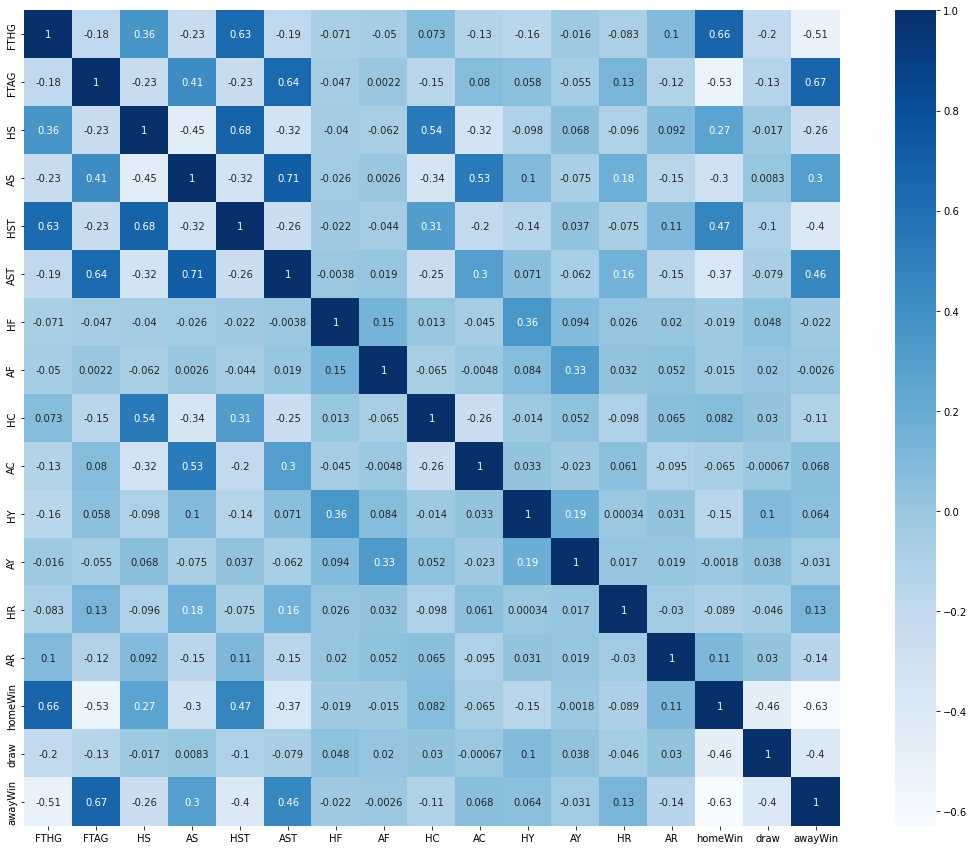

In [11]:
# Visualising the correlation matrix using a heatmap

fig, ax = plt.subplots(figsize = (20,15))
sns.heatmap(c_matrix, square = True, cmap = 'Blues', annot=True);

A lot of the variables that seem to be strong correlated with each other are unsurprising here as these are things we typically expect during a game. 
Examples include Home Shots and Home Shots on Target or Home Fouls and Home Yellow Cards. These types of things co-occur or are the direct result of the other so this is expected to be the case. 


## Variable correlation with win margin

To further investigate the relationship between variables we can look at the relationship each game statistic has with the winning margin to see if this heatmap changes and produces further insights. 

In [12]:
df['win_margin'] = df['FTHG'] - df['FTAG']

game_stat_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY','HR', 'AR', 'win_margin']

game_stat_corr = df[game_stat_cols].corr()
game_stat_corr['win_margin'].sort_values()

AST          -0.528945
AS           -0.416775
HY           -0.145916
HR           -0.138534
AC           -0.134106
AF           -0.034716
HF           -0.018273
AY            0.023787
HC            0.142644
AR            0.144062
HS            0.386541
HST           0.564223
win_margin    1.000000
Name: win_margin, dtype: float64

Focusing on the correlation between our feature columns or game statistics against the win margin there are things we can see that are not totally surprisng which most sports fan would expect to see. 
For example all variables that are positively correlated to the win margin (difference between Home Goals Scored and Away Goals Scored) are things such as Home Shots, Home Corners, Away Reds. 

There are however some variables we aren't expecting to see such as Home Yellows/Reds negatively correlating with winning margin however this could be due to several factors, one explanation being that the home side maybe tend to play much more aggresively if they are trailing in the game which could lead to more yellow/red cards.

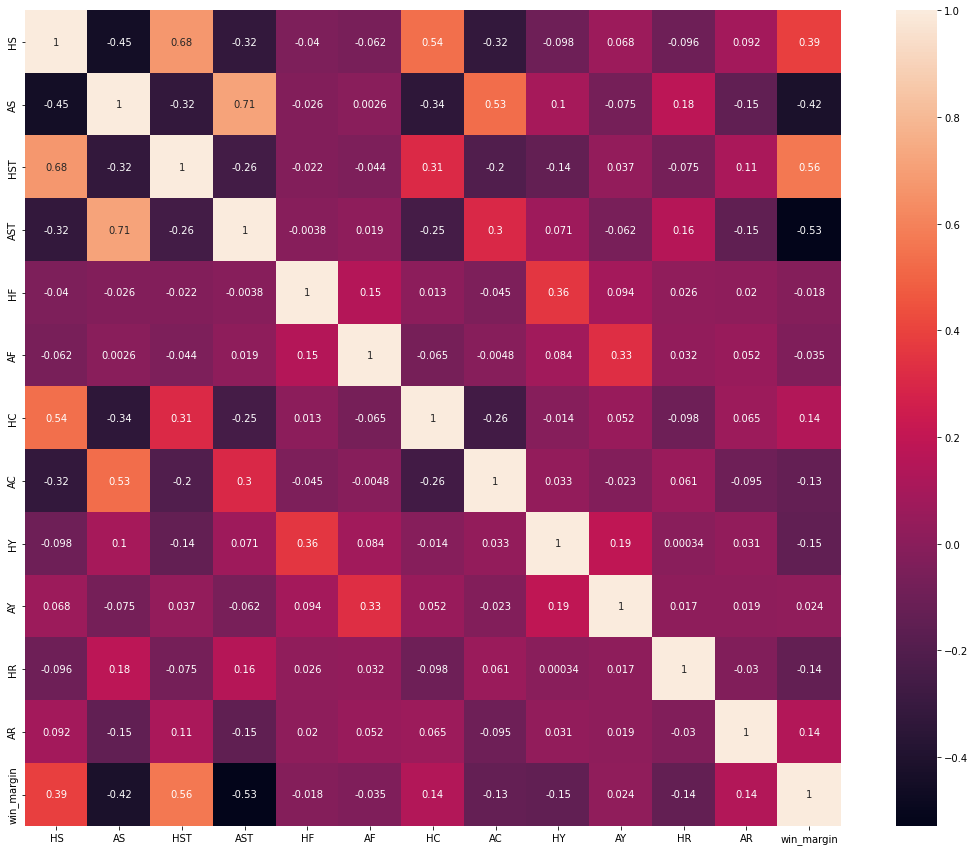

In [13]:
#Heatmap using game stat cols
fig, ax = plt.subplots(figsize = (20,15))
sns.heatmap(game_stat_corr, square = True, annot=True);

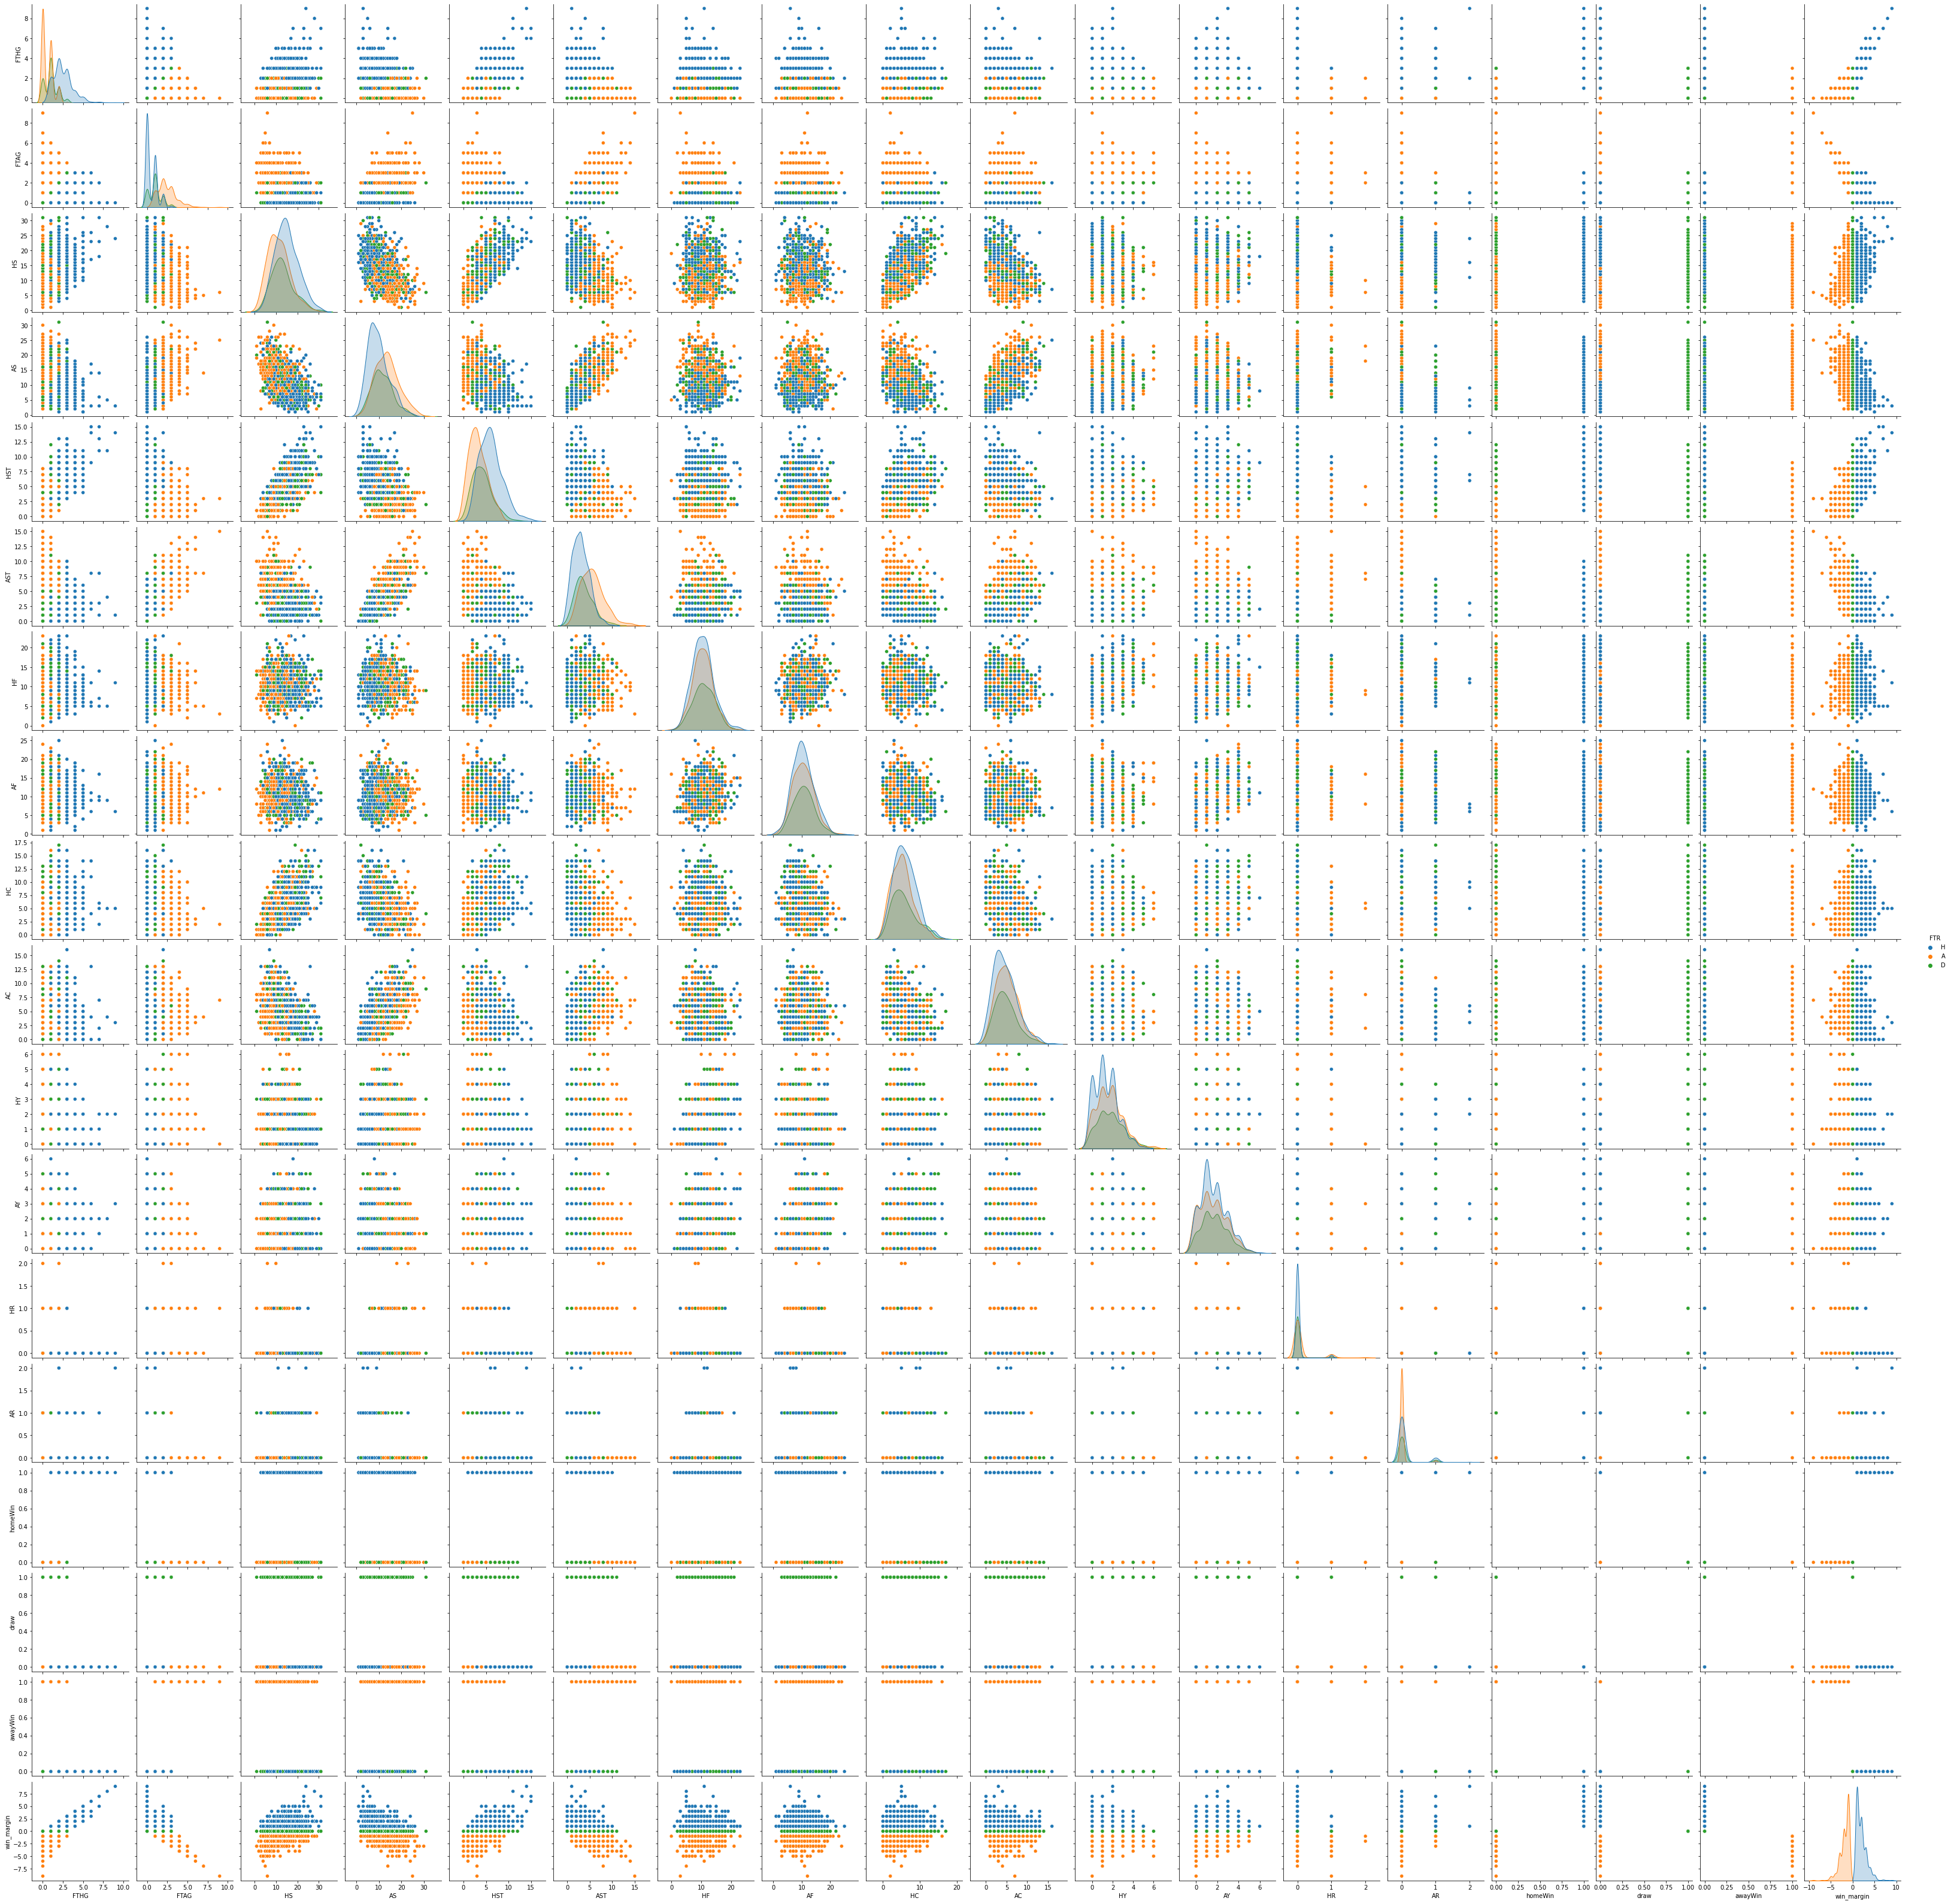

In [14]:
sns.pairplot(df, hue='FTR')

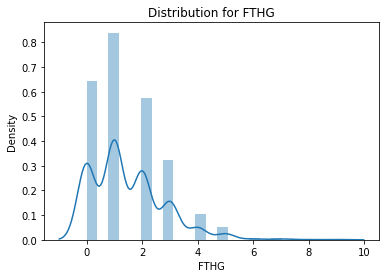

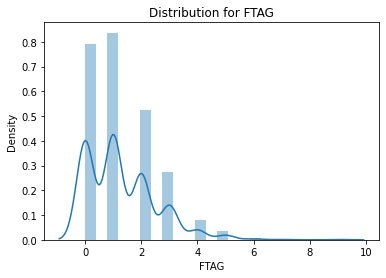

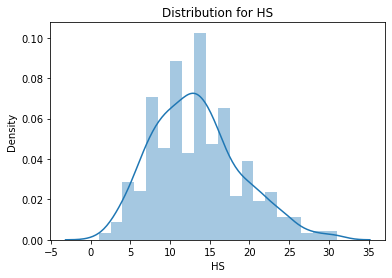

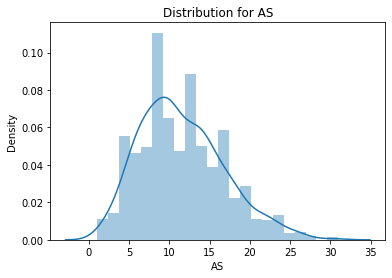

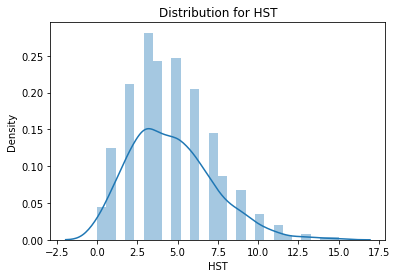

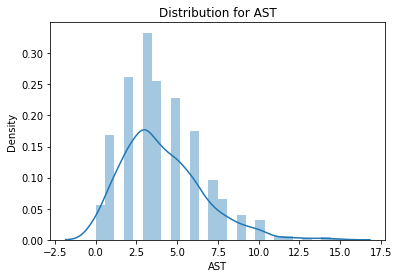

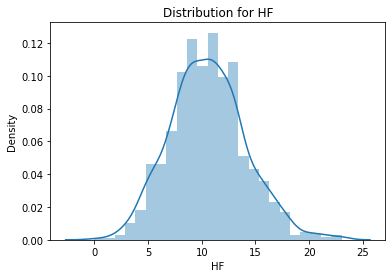

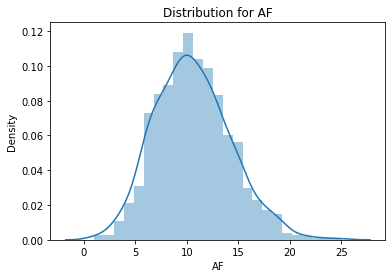

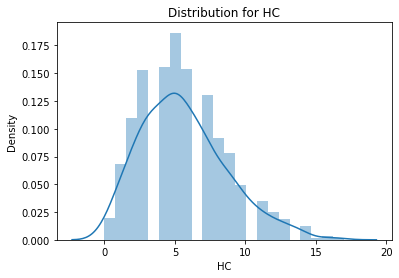

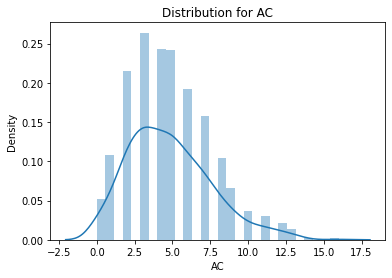

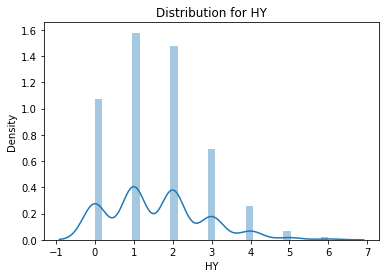

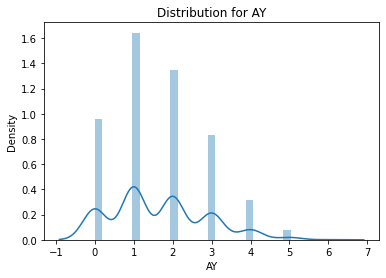

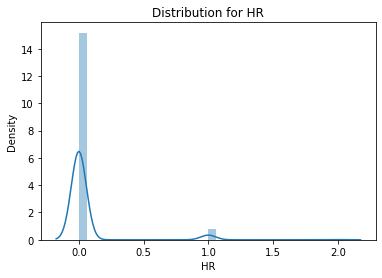

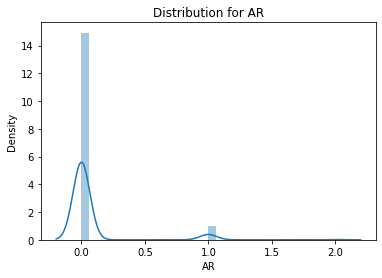

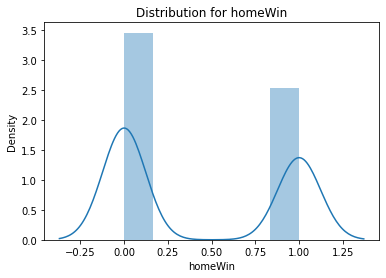

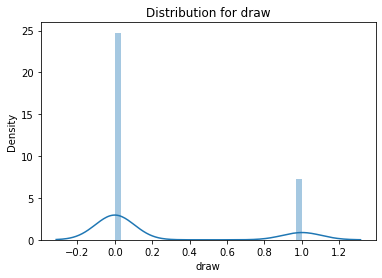

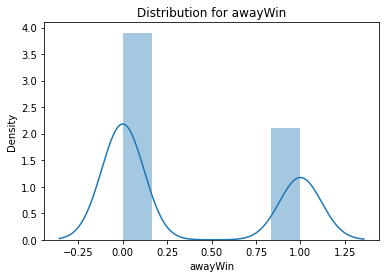

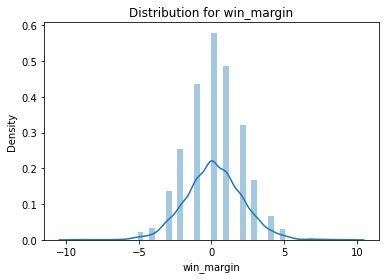

In [15]:
for col in df.select_dtypes('number').columns:
    sns.distplot(df[col])
    plt.title(f"Distribution for {col}")
    plt.show()

# Train ML models

In [16]:
# Replace H,A,D with numerical values for model usages
features = df.drop(['homeWin', 'draw', 'awayWin', 'Season', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'win_margin', 'Referee', 'FTR'], axis=1)
target_var = df[['FTR']].replace(['H','A','D'], [0,1,2])
target_var_latest = df_latest_season[['FTR']].replace(['H','A','D'], [0,1,2])

In [17]:
# Split the data into test and train datasets. 

X_train, X_test, y_train, y_test = train_test_split(features, target_var, test_size=0.2, random_state=42, stratify=target_var)

In [18]:
# Listing out all ML models to pass the data on . 

names = ["K-Nearest Neighbors", "Logistic Regression","Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest Classifier", "Multi-layer Perceptron Classifier (Neural Network)", "AdaBoost",
         "Naive Bayes", "QuadraticDiscriminantAnalysis"]

classifiers = [
    KNeighborsClassifier(n_neighbors = 3),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [19]:
# Iterate through each classifier and produce accuracy scores. 

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)

        prediction_proba = clf.predict_proba(X_test)
        logloss = log_loss(y_test,prediction_proba)
        precision, recall, fscore, support = score(y_test, y_predict)
        conf_martrix = confusion_matrix(y_test, y_predict)
        clas_report = classification_report(y_test, y_predict)

        print(name, accuracy)
        print(clas_report)

K-Nearest Neighbors 0.6076555023923444
              precision    recall  f1-score   support

           0       0.61      0.79      0.69        89
           1       0.67      0.58      0.62        73
           2       0.48      0.32      0.38        47

    accuracy                           0.61       209
   macro avg       0.59      0.56      0.56       209
weighted avg       0.60      0.61      0.59       209

Logistic Regression 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        73
           2       1.00      1.00      1.00        47

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209

Linear SVM 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        

The above results seem to suggest that there are a few models that give us a 100% prediction rate however this is highly unlikely and there may be something incorrect with the way the data is interacting with the models that is causing this error. 

There could be a number of reasons why this is occuring:  

- Overfitting: The models maybe be overfitting the training data indicating that the data might have a lot of noise in it therefore the models are learning the noise rather than the underlying trends.  
- Data imbalance: The data may have an imbalance with several classes.
- Too many features: if there are features that arent relevant to the prediction or if there are features that are highly correlated the models may be able to predict this purely by chance. 

From the reasons I provided earlier it may be the case that too many features were selected causing noise. I pointed out earlier there are some variables that co-occur for example Home Shot and Home Shots on Target which could be interfering with the performance of the model.  

Therefore I will go through another iteration of model tuning with better feature selection this round. 

## Recursive Feature Selection (RFE)

Recusive Feature Elimination or RFE is a popular feature selection algorithm which is easy to use and helps select features from the dataset provided that are relevant for predicting the target variable, while eliminating those that are not as important. RFE works by recursively removing features one at a time, and then building a model using the remaining features. The feature that results in the lowest performance of the model is then removed, and this process is repeated until a desired number of features is reached. This method is useful in cases where there are a large number of features, and it is difficult to identify which ones are important.

https://machinelearningmastery.com/rfe-feature-selection-in-python/ 




In [20]:
# RFE SELECTED   features 
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(features)
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=6, step=10, verbose=5)
rfe_selector.fit(X_norm, target_var)
rfe_support = rfe_selector.get_support()
rfe_feature = features.loc[:,rfe_support].columns.tolist()


print(str(len(rfe_feature)), 'selected features')

# Features chosen by RFE algorithm
rfe_feature

Fitting estimator with 14 features.
6 selected features


['FTHG', 'FTAG', 'HST', 'AST', 'AC', 'AR']

In [21]:
# Fitting models with RFE selections


features_rfe = features[rfe_feature]

In [22]:
# Split the data into test and train datasets. 

X_train, X_test, y_train, y_test = train_test_split(features_rfe, target_var, test_size=0.2, random_state=42, stratify=target_var)

In [23]:
# Listing out all ML models to pass the data on . 

names = ["K-Nearest Neighbors", "Logistic Regression","Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest Classifier", "Multi-layer Perceptron Classifier (Neural Network)", "AdaBoost",
         "Naive Bayes", "QuadraticDiscriminantAnalysis"]

classifiers = [
    KNeighborsClassifier(n_neighbors=3),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [24]:
# Iterate through each classifier and produce accuracy scores. 

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        clas_report = classification_report(y_test, y_predict)

        print(name, accuracy)
        print(clas_report)

K-Nearest Neighbors 0.784688995215311
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        89
           1       0.84      0.86      0.85        73
           2       0.54      0.40      0.46        47

    accuracy                           0.78       209
   macro avg       0.74      0.73      0.73       209
weighted avg       0.77      0.78      0.77       209

Logistic Regression 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        73
           2       1.00      1.00      1.00        47

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209

Linear SVM 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        7

Even with the RFE technique to give us the most relevant features we are still seeing 100% predictions for several models (which I don't think can be correct). 

Next I will run the models again with some handpicked selections

In [25]:
my_features = features[['HY', 'AY', 'HST', 'AST', 'AC', 'HC']]

In [26]:
# Split the data into test and train datasets. 

X_train, X_test, y_train, y_test = train_test_split(my_features, target_var, test_size=0.2, random_state=42, stratify=target_var)

In [27]:
# Listing out all ML models to pass the data on . 

names = ["K-Nearest Neighbors", "Logistic Regression","Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest Classifier", "Multi-layer Perceptron Classifier (Neural Network)", "AdaBoost",
         "Naive Bayes", "QuadraticDiscriminantAnalysis"]

classifiers = [
    KNeighborsClassifier(n_neighbors=3),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [28]:
# Iterate through each classifier and produce accuracy scores. 

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        clas_report = classification_report(y_test, y_predict)

        print(name, accuracy)
        print(clas_report)

K-Nearest Neighbors 0.5215311004784688
              precision    recall  f1-score   support

           0       0.56      0.73      0.63        89
           1       0.55      0.48      0.51        73
           2       0.32      0.19      0.24        47

    accuracy                           0.52       209
   macro avg       0.47      0.47      0.46       209
weighted avg       0.50      0.52      0.50       209

Logistic Regression 0.583732057416268
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        89
           1       0.56      0.71      0.63        73
           2       0.33      0.09      0.14        47

    accuracy                           0.58       209
   macro avg       0.51      0.51      0.48       209
weighted avg       0.54      0.58      0.54       209

Linear SVM 0.5933014354066986
              precision    recall  f1-score   support

           0       0.64      0.74      0.69        89
           1       0.5

Using my handpicked selections it seems to have rectified the error of 100% accuracy prediction. 
Whilst investigating the causes of this and also the RFE feature selection I realised the error I had made, I was using two variables (Goals scored - Home and Away) within the models. This is key as essentially these basically give you scoreline and the resulting outcome of a given match. The models were therefore using these variables for predictions which is obviously going to give you a 100% prediction rate. 

After I removed these features and inserted the other statistics the models are now showing a realistic prediction outcome averaging around the 60% accuracy for most of the models chosen. 

# Tuning the hyperparameters of a model 

https://scikit-learn.org/stable/modules/grid_search.html 

I will use the Logistic Regression model to tune with cross validation using grid search. 
Grid Search attempts each combination of values and finds the most suitable model with the lowest error metrics usually the log loss for the Logisitic Regression model. 

In [29]:
# Defining parameters for grid search
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix
df_latest_season_features = df_latest_season[['HY', 'AY', 'HST', 'AST', 'AC', 'HC']]
LogReg_Grid = {
    "C": [0.0001, 0.01, 0.05, 0.2, 1],
    "solver": ["newton-cg", "lbfgs", "liblinear"]
}

k_fold = StratifiedKFold(n_splits=5)

GridSearch = GridSearchCV(LogisticRegression(), param_grid=LogReg_Grid, cv=k_fold, scoring='neg_log_loss')
GridSearch.fit(my_features, target_var)
print("Best log loss: {}".format(GridSearch.best_score_ *-1))
best_logreg_params = GridSearch.best_params_

Best log loss: 0.835325555462008


In [30]:
logreg = LogisticRegression(**best_logreg_params) # Instantiate the model
logreg.fit(X_train, y_train) # Fit our model
logreg_predict = logreg.predict(df_latest_season_features) # Predict the current season values

In [31]:
# Create a confusion matrix
c_matrix = (pd.DataFrame(confusion_matrix(target_var_latest, logreg_predict))
 .rename_axis('Actual')
 .rename_axis('Predicted', axis='columns'))

c_matrix

Predicted  0  1  2
Actual            
0          6  1  2
1          2  1  1
2          2  5  0

We can see above that whilst we are somewhat able to predict Home Wins and Away wins in general the draws are quite not predicting as good as the wins. This is also the case in real life it is much more difficult to predict draws on the day. 

<span id="fn1"> </span>